In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
from IPython.display import display
import textwrap
import json 
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

## Import speech dataset and preprocessed data for lda

In [3]:
# import parllaw speech dataset
filename = "data/parllaw/speech_translated.csv"

df = pd.read_csv(filename)
df["year"] = df.apply(lambda s: int(s["date"][:4]), axis=1)
df["uq_agenda"] = df["agenda"]+df["date"]

In [4]:
# import preprocessed data: tokenization, lemmatization, stopword removal
preprocessed_data = json.load(open("data/lda/preprocessed_texts_all_translated.json"))

## Adjust party variable

In [5]:
# only use speeches where speaker is associated with a party
df_party_members = df[~(df["party"] == "-")]

# only keep speeches with at least 50 characters: important for coherence with preprocessed data
df_party_members = df_party_members[df_party_members["translatedText"].map(str).map(len) > 50]
print(len(df_party_members))
assert len(df_party_members) == len(preprocessed_data)

# merge parties that changed names over time
df_party_members['party_adj'] = df_party_members['party']  # start with a copy

df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_adj'] = 'PSE/S&D' # PSE becomes S&D
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_adj'] = 'PPE' # PPE-DE' becomes 'PPE'
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD']), 'party_adj'] = 'EFD' # 'EFDD' becomes 'EFD'
df_party_members.loc[df_party_members['party'].isin(['ITS', 'ENF', 'ID']), 'party_adj'] = 'ENF/ID' # ENF becomes ID in 2019
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_adj'] = 'ELDR/ALDE/Renew' # ELDR becomes ALDE becomes Renew
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_adj'] = 'NGL/The Left' # GUE/NGL becomes The Left
df_party_members.loc[df_party_members['party'].isin(['IND/DEM','EDD']), 'party_adj'] = 'INDDEM/EDD' # independents become EDD

# print information
display(df_party_members["party_adj"].value_counts())

# create broader party blocks
df_party_members['party_block'] = df_party_members['party']  # start with a copy

# left
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_block'] = 'left'
# green
df_party_members.loc[df_party_members['party'].isin(['Greens/EFA']), 'party_block'] = 'greens'
# social democratic
df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_block'] = 'social_democratic'
# christian conservative
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_block'] = 'christian_conservative'
# liberal
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_block'] = 'liberal'
# right populist
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD','ITS', 'ENF', 'ID', 'IND/DEM', 'ECR', 'UEN', 'EDD']), 'party_block'] = 'right_populist'

# print information
display(df_party_members["party_block"].value_counts())

df_party_members = df_party_members.reset_index(drop=True)

# create color legend for party blocks
party_block_colors = {
    'left': 'purple',
    'greens': 'green',
    'social_democratic': 'red',
    'christian_conservative': 'black',
    'liberal': 'orange',
    'right_populist': 'blue'
}

505705


party_adj
PPE                162460
PSE/S&D            119501
NGL/The Left        46465
ELDR/ALDE/Renew     42610
ECR                 29222
Greens/EFA          26260
NI                  26147
EFD                 22172
ENF/ID              20787
UEN                  5171
INDDEM/EDD           4436
TGI                   474
Name: count, dtype: int64

party_block
christian_conservative    162460
social_democratic         119501
right_populist             81788
left                       46465
liberal                    42610
greens                     26260
NI                         26147
TGI                          474
Name: count, dtype: int64

## DUPLICATE SCANDAL

488668
17037 number of duplicates


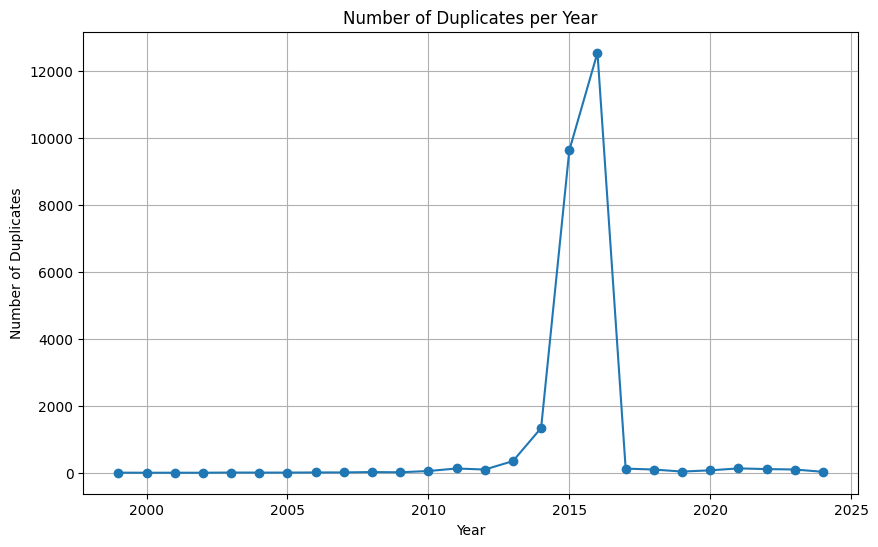

In [6]:
print(len(df_party_members["translatedText"].unique()))
print(len(df_party_members)- len(df_party_members["translatedText"].unique()), "number of duplicates")  # check for duplicates

df_duplicates = df_party_members[df_party_members["text"].duplicated(keep=False)]
len(df_party_members) - len(df_duplicates)

# plot number of duplicates per year
duplicates_per_year = df_duplicates['year'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(duplicates_per_year.index, duplicates_per_year.values, marker='o')
plt.title('Number of Duplicates per Year')
plt.xlabel('Year')
plt.ylabel('Number of Duplicates')
plt.grid()
plt.show()

In [7]:
# df_duplicates[df_duplicates["written"]==False]
# # group by text and check uniqueness of party, uq_agenda and date
# grp = df_duplicates.groupby("text").agg(
#     n_speeches=("text", "size"),
#     party_nunique=("party", "nunique"),
#     uq_agenda_nunique=("uq_agenda", "nunique"),
#     date_nunique=("date", "nunique"),
# ).reset_index()

# # only keep texts that occur more than once
# dup_groups = grp[grp["n_speeches"] > 1]

# # find groups where any of the fields vary
# inconsistent = dup_groups[
#     # (dup_groups["party_nunique"] > 1)
#     # (dup_groups["uq_agenda_nunique"] > 1)
#     (dup_groups["date_nunique"] > 1)
# ].copy()

# print(f"Total duplicate-text groups: {len(dup_groups)}")
# print(f"Inconsistent groups (party / uq_agenda / date differ): {len(inconsistent)}")

# # show a few examples of inconsistent groups and the actual rows for inspection
# if len(inconsistent) > 0:
#     display(inconsistent.head(10))
#     display(df_duplicates[df_duplicates["text"].isin(inconsistent["text"])].sort_values(["text", "date"]).head(30))
# else:
#     print("All duplicate texts have identical party, uq_agenda and date.")


In [8]:
# for now: only keep the first occurrence of each speech
df_party_members = df_party_members.sort_values(by=["date"]).drop_duplicates(subset=["translatedText"], keep="first").reset_index(drop=True)
print(len(df_party_members))

488668


## LDA: Define 50 (highest coherence) topics and assign their probabilities to each speech

In [9]:
print("creating dictionary")
dictionary = corpora.Dictionary(preprocessed_data)
print("filtering dictionary")
dictionary.filter_extremes(
    no_below=10,     # Keep tokens appearing in at least 10 docs
    no_above=0.4,    # Remove tokens appearing in more than 40% of docs
    keep_n=100000    # Keep only the top 100k words by frequency
)
corpus = [dictionary.doc2bow(l) for l in tqdm(preprocessed_data, "Preparing corpus")]

creating dictionary
filtering dictionary


Preparing corpus: 100%|██████████| 505705/505705 [00:24<00:00, 20239.42it/s]


In [10]:
def print_topics(model, n_topics, k_words=5):
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx}: {label}")

In [11]:
def assign_topics(lda_model, corpus):
    # choose the LDA model to use (change if you want a different one)
    topics = []
    for bow in tqdm(corpus, desc="Assigning most probable topic to each doc"):
        docs_topics = lda_model.get_document_topics(bow, minimum_probability=0)
        topics.append(docs_topics)
    return topics

## Assign topics to speeches using pre-trained model

In [12]:
n_topics = 50
n_passes = 10 # both chosen in earlier evaluation
model = LdaModel.load(f"data/lda/{n_topics}_topics/{n_passes}/model.model")

corpus_topics = assign_topics(model, corpus)
# set up df with topic probabilities

# corpus topics is a list of lists of (topic_id, probability) tuples for each document in the corpus
# this list is turned into dataframe of size (num_docs, num_topics) with probabilities
num_docs = len(corpus_topics)
num_topics = n_topics
topic_prob_matrix = np.zeros((num_docs, num_topics))
for doc_idx, doc_topics in enumerate(corpus_topics):
    for topic_id, prob in doc_topics:
        topic_prob_matrix[doc_idx, topic_id] = prob
topic_prob_df = pd.DataFrame(topic_prob_matrix, columns=[f"topic_{i}" for i in range(num_topics)])

# append topic probabilities to df_party_members
df_topics = pd.concat([df_party_members.reset_index(drop=True), topic_prob_df], axis=1)

# exlude "NI" and "TGI" from party columns, these are non-inscrits and technical group without party affiliation
df_topics = df_topics[~df_topics["party"].isin(["NI", "TGI"])]

Assigning most probable topic to each doc:  92%|█████████▏| 466384/505705 [02:00<00:10, 3883.10it/s]


IndexError: index 27117 is out of bounds for axis 1 with size 27117

In [ ]:
# print list of topics
print_topics(model, n_topics)

## Explore topics of interest

In [ ]:
# some plotting parameters
election_years = [1999, 2004, 2009, 2014, 2019, 2024]

In [ ]:
def explore_topic(topic_id, model=model, df_topics=df_topics, top_n_terms=10, speech_number=10, prob_threshold=0.25):
    # define df_selected_topic
    df_selected_topic = df_topics[df_topics[f'topic_{topic_id}'] >= prob_threshold]

    # return first 10 words and their probabilities for topic of interest
    topic_terms = model.get_topic_terms(topicid=topic_id, topn=top_n_terms)
    terms_with_words = [(dictionary[id], prob) for id, prob in topic_terms]
    print(f"Topic {topic_id} terms:")
    for word, prob in terms_with_words:
        print(f"  {word}: {prob:.4f}")
    # save first three words
    first_3_words = [dictionary[id] for id, prob in topic_terms[:3]]

    # number of speeches in topic
    n_speeches = df_selected_topic.shape[0]
    print(f"Number of speeches in topic {topic_id} ({first_3_words}) with prob >= {prob_threshold}): {n_speeches}")
    
    # return top speeches
    print(f"Top speeches for topic {topic_id} ({first_3_words}):\n")
    df_selected_topic_sorted_desc = df_selected_topic.sort_values(by=f"topic_{topic_id}", ascending=False)
    for i in range(speech_number):
        speech = df_selected_topic_sorted_desc.iloc[i]
        print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
        print(textwrap.fill(speech["translatedText"], width=80))
        print("\n" + "-"*80 + "\n")

    # return speeches just above threshold
    print(f"Just passing speeches for topic {topic_id} ({first_3_words}):\n")
    df_selected_topic_sorted = df_selected_topic.sort_values(by=f"topic_{topic_id}")
    for i in range(speech_number):
        speech = df_selected_topic_sorted.iloc[i]
        print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
        print(textwrap.fill(speech["translatedText"], width=80))
        print("\n" + "-"*80 + "\n")

    # plot 
    # plots: number and ratio of speeches per year and party block
    party_blocks = df_selected_topic['party_block'].unique()
    years = sorted(df_selected_topic['year'].unique())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    for party_block in party_blocks:
        counts_per_year = []
        normalized_counts_per_year = []
        for year in years:
            count = df_selected_topic[(df_selected_topic['party_block'] == party_block) & (df_selected_topic['year'] == year)].shape[0]
            counts_per_year.append(count)
            total_count = df_topics[(df_topics['party_block'] == party_block) & (df_topics['year'] == year)].shape[0]
            normalized_count = count / total_count if total_count > 0 else 0
            normalized_counts_per_year.append(normalized_count)
        ax1.plot(years, counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
        ax2.plot(years, normalized_counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
    for year in election_years:
        ax1.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
        ax2.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
    ax1.set_xticks(election_years)
    ax2.set_xticks(election_years)
    # add horizontal grid lines
    ax1.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
    ax2.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
    ax1.set_title(f"Number of speeches per year for topic {topic_id} ({first_3_words})")
    ax1.set_ylabel("Number of speeches")
    ax1.legend()
    ax2.set_title(f"Ratio of speeches per year for topic {topic_id} ({first_3_words})")
    ax2.set_ylabel("Ratio of speeches")
    ax2.set_xlabel("Year")
    ax2.legend()
    plt.tight_layout()
    plt.show()    

    return df_selected_topic

In [ ]:
def compare_topics(topic_id_list, model=model, df_topics=df_topics, top_n_terms=10, speech_number=5, prob_threshold=0.25):
    # for each topic, plot the number of speeches of that topic divided by total speeches per year
    years = sorted(df_topics['year'].unique())
    fig, ax = plt.subplots(figsize=(10, 6))
    for topic_id in topic_id_list:
        df_selected_topic = df_topics[df_topics[f'topic_{topic_id}'] >= prob_threshold]
        first_3_words = [dictionary[id] for id, prob in model.get_topic_terms(topicid=topic_id, topn=3)]
        ratios_per_year = []
        for year in years:
            count = df_selected_topic[df_selected_topic['year'] == year].shape[0]
            total_count = df_topics[df_topics['year'] == year].shape[0]
            ratio = count / total_count if total_count > 0 else 0
            ratios_per_year.append(ratio)
        ax.plot(years, ratios_per_year, label=f"Topic {topic_id} ({', '.join(first_3_words)})", marker='o')
    for year in election_years:
        ax.axvline(x=year, color='gray', linestyle='-', alpha=0.5)
    ax.set_xticks(election_years)
    ax.set_title(f"Ratio of speeches per year for selected topics")
    ax.set_ylabel("Ratio of speeches")
    ax.set_xlabel("Year")
    ax.legend()
    ax.yaxis.grid(True, linestyle='-', color='gray', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
compare_topics([1, 4, 16, 34, 43])

In [ ]:
df_migration = explore_topic(8)

### old code: delete before handing in

In [ ]:
# # return first 10 words and their probabilities for topic of interest
# topic_terms = model.get_topic_terms(topicid=topic_id, topn=10)
# terms_with_words = [(dictionary[id], prob) for id, prob in topic_terms]
# print(f"Topic {topic_id} terms:")
# for word, prob in terms_with_words:
#     print(f"  {word}: {prob:.4f}")
# # save first three words
# first_3_words = [dictionary[id] for id, prob in topic_terms[:3]]

# # set up dataset with only speeches related to that topic
# prob_threshold = 0.25
# df_selected_topic = df_topics[df_topics[f"topic_{topic_id}"] >= prob_threshold]
# print(f"Number of speeches in topic {topic_id} ({first_3_words}) with prob >= {prob_threshold}): {df_selected_topic.shape[0]}")

In [ ]:
# # 5 speeches just above threshold
# print(f"Just passing speeches for topic {topic_id} ({first_3_words}):\n")
# df_selected_topic_sorted = df_selected_topic.sort_values(by=f"topic_{topic_id}")
# speech_number = 5
# for i in range(speech_number):
#     speech = df_selected_topic_sorted.iloc[i]
#     print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
#     print(textwrap.fill(speech["translatedText"], width=80))
#     print("\n" + "-"*80 + "\n")

In [ ]:
# # top 5 speeches with highest probability
# print(f"Top speeches for topic {topic_id} ({first_3_words}):\n")
# df_selected_topic_sorted_desc = df_selected_topic.sort_values(by=f"topic_{topic_id}", ascending=False)
# speech_number = 5
# for i in range(speech_number):
#     speech = df_selected_topic_sorted_desc.iloc[i]
#     print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
#     print(textwrap.fill(speech["translatedText"], width=80))
#     print("\n" + "-"*80 + "\n")

In [ ]:
# # create color legend for party blocks
# party_block_colors = {
#     'left': 'purple',
#     'greens': 'green',
#     'social_democratic': 'red',
#     'christian_conservative': 'black',
#     'liberal': 'orange',
#     'right_populist': 'blue'
# }

In [ ]:
# # plots: number and ratio of speeches per year and party block
# party_blocks = df_selected_topic['party_block'].unique()
# years = sorted(df_selected_topic['year'].unique())
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# for party_block in party_blocks:
#     counts_per_year = []
#     normalized_counts_per_year = []
#     for year in years:
#         count = df_selected_topic[(df_selected_topic['party_block'] == party_block) & (df_selected_topic['year'] == year)].shape[0]
#         counts_per_year.append(count)
#         total_count = df_topics[(df_topics['party_block'] == party_block) & (df_topics['year'] == year)].shape[0]
#         normalized_count = count / total_count if total_count > 0 else 0
#         normalized_counts_per_year.append(normalized_count)
#     ax1.plot(years, counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
#     ax2.plot(years, normalized_counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
# ax1.set_title(f"Number of speeches per year for topic {topic_id} ({first_3_words})")
# ax1.set_ylabel("Number of speeches")
# ax1.legend()
# ax2.set_title(f"Ratio of speeches per year for topic {topic_id} ({first_3_words})")
# ax2.set_ylabel("Ratio of speeches")
# ax2.set_xlabel("Year")
# ax2.legend()
# ax1.grid(True)
# ax2.grid(True)
# plt.tight_layout()
# plt.show()

### basic interpretation: topic 9 is more neutral refugee, topic 39 is more related to the situation in italy, and more pushed by right-wing populists

In [ ]:
# # get migration dataset
# topic_id_migration_neutral = 8
# topic_id_migration_italy = 39
# df_migration_neutral = df_topics[df_topics[f"topic_{topic_id_migration_neutral}"] >= prob_threshold]
# print(f"Number of speeches in topic migration_neutral (topic {topic_id_migration_neutral} with prob >= {prob_threshold}): {df_migration_neutral.shape[0]}")
# df_migration_italy = df_topics[df_topics[f"topic_{topic_id_migration_italy}"] >= prob_threshold]
# print(f"Number of speeches in topic migration_italy (topic {topic_id_migration_italy} with prob >= {prob_threshold}): {df_migration_italy.shape[0]}")

### Test: Display migration speeches with lowest probability that is still above threshold

In [ ]:
# df_migration_sorted_neutral = df_migration_neutral.sort_values(by=f"topic_{topic_id_migration_neutral}")
# speech_number = 10
# print("Just passing speeches for migration_neutral topic:")
# for idx, row in df_migration_sorted_neutral.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_neutral}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

In [ ]:
# df_migration_sorted_italy = df_migration_italy.sort_values(by=f"topic_{topic_id_migration_italy}")
# speech_number = 10
# print("Just passing speeches for migration_italy topic:")
# for idx, row in df_migration_sorted_italy.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_italy}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

### Test: Display speeches with highest probability

In [ ]:
# df_migration_sorted_neutral = df_migration_neutral.sort_values(by=f"topic_{topic_id_migration_neutral}", ascending=False)
# speech_number = 10
# print("Top speeches for migration_neutral topic:")
# for idx, row in df_migration_sorted_neutral.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_neutral}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

In [ ]:
# df_migration_sorted_italy = df_migration_italy.sort_values(by=f"topic_{topic_id_migration_italy}", ascending=False)
# speech_number = 10
# print("Top speeches for migration_italy topic:")
# for idx, row in df_migration_sorted_italy.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_italy}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

In [ ]:
# # save combined migration data to csv
# df_migration = pd.concat([df_migration_neutral, df_migration_italy]).drop_duplicates().reset_index(drop=True)
# df_migration = df_migration_neutral
# df_migration.to_csv("migration_speeches_lda.csv", sep="\t")

In [ ]:
# # plot number of speeches in topic 9 and 39 per year
# migration_neutral_counts_per_year = df_migration_neutral['year'].value_counts().sort_index()
# migration_italy_counts_per_year = df_migration_italy['year'].value_counts().sort_index()
# plt.figure(figsize=(8, 4))
# plt.plot(migration_neutral_counts_per_year.index, migration_neutral_counts_per_year.values, marker='o', label='Migration Neutral (Topic 9)')
# plt.plot(migration_italy_counts_per_year.index, migration_italy_counts_per_year.values, marker='o', label='Migration Italy (Topic 39)')
# plt.title('Number of Migration-Related Speeches per Year')
# plt.xlabel('Year')
# plt.ylabel('Number of Speeches')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # normalized plot: ratio of migration speeches to total speeches per year
# speech_counts_per_year = df_party_members['year'].value_counts().sort_index()
# ratio_neutral_per_year = migration_neutral_counts_per_year / speech_counts_per_year
# ratio_neutral_per_year = ratio_neutral_per_year.dropna()  # remove NaN values
# ratio_italy_per_year = migration_italy_counts_per_year / speech_counts_per_year
# ratio_italy_per_year = ratio_italy_per_year.dropna()  # remove NaN values
# plt.figure(figsize=(6, 4))
# plt.plot(ratio_neutral_per_year.index, ratio_neutral_per_year.values, marker='o', label='Migration Neutral (Topic 9)')
# plt.plot(ratio_italy_per_year.index, ratio_italy_per_year.values, marker='o', label='Migration Italy (Topic 39)')
# plt.title('Ratio of Migration-Related Speeches per Year')
# plt.xlabel('Year')
# plt.ylabel('Ratio of Speeches')
# plt.legend()
# plt.grid()
# plt.show()

In [ ]:
# # Create figure with 3 subplots
# fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# # Define datasets and titles
# datasets = [
#     (df_migration, 'Migration_Combined'),
#     (df_migration_neutral, 'Migration_Neutral'),
#     (df_migration_italy, 'Migration_Italy')
# ]

# # Plot each dataset
# for ax, (data, title) in zip(axes, datasets):
#     for party_block in data['party_block'].unique():
#         party_block_data = data[data['party_block'] == party_block]
#         counts_per_year = party_block_data['year'].value_counts().sort_index()
#         ax.plot(counts_per_year.index, counts_per_year.values, marker='o', 
#                 label=party_block, color=party_block_colors.get(party_block))
    
#     ax.set_title(f'Number of {title} Speeches per Year by Party Block')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Number of Speeches')
#     ax.legend()
#     ax.grid()

# plt.tight_layout()
# plt.show()


In [ ]:
# # Create single figure with all three migration datasets
# fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# # Define datasets and titles
# datasets = [
#     (df_migration, 'Migration_Combined'),
#     (df_migration_neutral, 'Migration_Neutral'),
#     (df_migration_italy, 'Migration_Italy')
# ]

# # Plot each dataset
# for ax, (data, title) in zip(axes, datasets):
#     for party_block in data['party_block'].unique():
#         party_block_data = data[data['party_block'] == party_block]
#         counts_per_year = party_block_data['year'].value_counts().sort_index()
#         total_counts_per_year = df_party_members[df_party_members['party_block'] == party_block]['year'].value_counts().sort_index()
#         ratio_per_year = counts_per_year / total_counts_per_year
#         ratio_per_year = ratio_per_year.dropna()
#         ax.plot(ratio_per_year.index, ratio_per_year.values, marker='o', 
#                 label=party_block, color=party_block_colors.get(party_block))
    
#     ax.set_title(f'Ratio of {title} Speeches per Year by Party Block')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Ratio of Speeches')
#     ax.legend()
#     ax.grid()

# plt.tight_layout()
# plt.show()


## Old approach: Use Keyword search to find relevant agendas / speeches

In [ ]:
# keywords = ["(M|m)igration", "(M|m)igrant", "(R|r)efugee", "(A|a)sylum", "(T|t)hird(-)?country national"]#, "(F|f)rontex"]
# indices_keyword_identified_speeches = df_party_members.index[df_party_members["uq_agenda"].str.contains("|".join(keywords))].tolist()
# TODO: potentially find relevant keywords using word2vec over text and look for words similar to migration? 

In [ ]:
# def filter_for_keywords(df, column="agenda", keywords=keywords, min_contributions_per_agenda_item=10): 
#     relevant_indices = df[column].str.contains("|".join(keywords))
#     agenda_items_vc = df[relevant_indices]["uq_agenda"].value_counts()
    
#     # TODO: do this filtering in the beginning because why not
#     n_agenda_items_before = len(agenda_items_vc)
#     relevant_agendas = agenda_items_vc[agenda_items_vc > min_contributions_per_agenda_item]
#     n_agenda_items_after = len(relevant_agendas)
#     print(f"filtered {n_agenda_items_before-n_agenda_items_after} agenda items with < {min_contributions_per_agenda_item} speeches")
    
#     relevant_indices = relevant_indices & (df["uq_agenda"].isin(relevant_agendas.index))
    
#     print(f"n speeches: {len(df[relevant_indices])}")
#     print(f"n agendas: {n_agenda_items_after}")
    
#     return df[relevant_indices]

In [ ]:
# # agenda items per year; speech per year; 
# # party per agenda item
# # contribution per party per year
# # normalize by original 
# df_filtered = filter_for_keywords(df)

In [ ]:
# n_per_year_and_party = df_filtered.groupby(["year"]).size()#.unstack()

# ax = n_per_year_and_party.plot(kind="bar", stacked=False, figsize=(40, 5))
# shortened_labels = [l[:50]+"..." if len(l) > 50 else l for l in [lb.get_text() for lb in ax.get_xticklabels()]]
# _ = ax.set_xticklabels(shortened_labels)

In [ ]:
# vc = df_filtered["uq_agenda"].value_counts()
# vc

In [ ]:
# df_filtered_text = filter_for_keywords("text")

In [ ]:
# n = df_filtered_text["uq_agenda"].value_counts()
# print(n.min(), n.mean(), n.max())

# #df_filtered["uq_agenda"]
# print(len(n))
# # agendas that with more than 4 speeches with relevant keywords, that are not in the agendas that were discovered with keywords in title
# new_relevant_agendas = n[(n>4) & (~n.index.isin(df_filtered["uq_agenda"]))]
# new_relevant_agendas[:20]

In [ ]:
# def print_agenda(search_term, n_speeches=None): 
#     all_agendas = df[df["uq_agenda"].str.contains(search_term)]["uq_agenda"].unique()
#     for agenda in all_agendas: 
#         speeches = df[df["uq_agenda"] == agenda].sort_values(by="speechnumber", ascending=True)
#         print("Agenda:", (agenda[:30]+"..." if len(agenda) > 30 else agenda))
#         print("Nr of speeches:", len(speeches))
#         print("")
        
#         if n_speeches:
#             speeches = speeches[:n_speeches]
#         for _, r in speeches.iterrows(): 
#             print(f'({r["speechnumber"]}) {r["speaker"]} ({r['party']}): {r['text'] if not r['translatedText'] else r["translatedText"]}')

In [ ]:
# print_agenda("6.4. Situation of fundamental rights in the European Union in 2015", 10)
# print_agenda("7.7. The situation of women refugees and asylum seekers in the EU", 10)
# print_agenda("European Border and Coast Guard", 10)

## Model evaluation

In [ ]:
# def evaluate_model(lda_model, dictionary, compute_coherence=True): 
#     if compute_coherence: 
#         print("Computing coherence")
#         coherence_model = CoherenceModel(
#             model=lda_model, 
#             texts=preprocessed_data, 
#             dictionary=dictionary, 
#             coherence='c_v'  # most common coherence measure
#         )
#         coherence_score = coherence_model.get_coherence()
#         print("Coherence:", coherence_score)
#     else: 
#         coherence_score = None 
        
#     # compute which topics are related to migration 
#     migration_topic_indices = lda_model.get_term_topics(lda_model.id2word.token2id["migration"], minimum_probability=0)
#     print("Topics related to 'migration':", len(migration_topic_indices))
    
#     # check if any migration-related topic has probability > 0.05 (arbitrary threshold)
#     threshold = 0.05
#     high_topics = [(tid, prob) for tid, prob in migration_topic_indices if prob > threshold]
#     if len(high_topics) > 0:
#         print(f"Topics with probability > {threshold}: {high_topics}")
#     else:
#         print(f"No migration-related topic has probability > {threshold}")

#     # for each speech with migration-keyworded agenda, get most probable topic
#     topic_counts = Counter()
#     topic_probabilities = []
#     missmatches = 0 
#     for idx in indices_keyword_identified_speeches:
#         # if idx >= len(preprocessed_data):
#         #     break
#         bow = dictionary.doc2bow(preprocessed_data[idx])
#         topic_distribution = lda_model.get_document_topics(bow)
#         most_probable_topic = max(topic_distribution, key=lambda x: x[1])
#         topic_counts[most_probable_topic[0]] += 1
#         topic_probabilities.append(most_probable_topic[1])

#         if most_probable_topic[0] not in dict(migration_topic_indices):
#             missmatches += 1 # count how often the most probable topic is not a migration-related topic

#     print("Most common topics for migration-related speeches:", topic_counts.most_common(len(migration_topic_indices)))
#     print("Average probability of most probable topic for migration-related speeches:", sum(topic_probabilities) / len(topic_probabilities))
#     print("missmatches (most probable topic not migration-related):", missmatches, f"{missmatches / len(indices_keyword_identified_speeches):.2%}")

#     return len(high_topics), coherence_score, missmatches

In [ ]:
# n_topic_values = [90, 100, 120]
# n_workers = 8

# import os 
# for n_topics in n_topic_values: 
#     os.makedirs(f"lda/{n_topics}_topics", exist_ok=True)
#     out_path = f"lda/{n_topics}_topics/model.model"
#     num_topics = n_topics
#     n_passes = 5
#     workers = n_workers

#     print("Fitting model with", num_topics, "topics and", n_passes, "passes")
#     lda_model = LdaMulticore(corpus = corpus, id2word=dictionary, num_topics = num_topics, passes = n_passes, workers=workers)
#     lda_model.save(out_path)

#     # Evaluate model
#     evaluate_model(lda_model, dictionary)

### Old Function: Count topic assignments

In [ ]:
# def count_topic_assignments(corpus_topics, topic_id, prob_threshold=0.0):
#     total = 0
#     most_prob_count = 0
#     at_least_prob_count = 0

#     most_doc_indices = [] 

#     most_probabilities = []
#     at_least_probabilites = []
#     for i, doc_topics in tqdm(enumerate(corpus_topics), desc="Counting topic assignments"):
#         # skip empty entries
#         if not doc_topics:
#             continue
#         total += 1

#         most_topic, most_prob = max(doc_topics, key=lambda x: x[1])
#         if most_topic == topic_id:
#             most_prob_count += 1
#             most_probabilities.append(most_prob)
#             most_doc_indices.append(i)

#         # probability of the target topic (0.0 if absent)
#         prob_map = dict(doc_topics)
#         prob = prob_map.get(topic_id, 0.0)
#         if prob >= prob_threshold:
#             at_least_prob_count += 1
#             at_least_probabilites.append(prob)

#     if total == 0:
#         return ({
#             "total_docs": 0,
#             "most_prob_count": 0,
#             "at_least_prob_count": 0,
#             "most_avg_prob": 0.0, 
#             "at_least_avg_prob": 0.0,
#         }, [], [])

#     return ({
#         "total_docs": total,
#         "most_prob_count": most_prob_count,
#         "at_least_prob_count": at_least_prob_count, 
#         "most_avg_prob": sum(most_probabilities) / most_prob_count,
#         "at_least_avg_prob": sum(at_least_probabilites) / at_least_prob_count,  
#     }, most_doc_indices, most_probabilities)